# COMS4061A - Reinforcement Learning

## Multi-Armed Bandits - Exercise

### Imports

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
%matplotlib inline

### Interface class

In [31]:
class MAB(ABC):
    def __init__(self, arms):
        self.arms = arms
        self.means = np.random.normal(0, 3, arms)
        self.var = 1
        
    @abstractmethod
    def pull(self):
        pass
    
    @abstractmethod
    def run_experiment(self, iterations):
        pass

### Epsilon Greedy

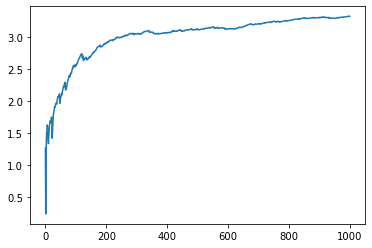

In [45]:
class EpsilonGreedy(MAB):
    def __init__(self, arms, epsilon):
        super().__init__(arms)
        self.epsilon = epsilon
        self.mean_rewards = np.zeros(arms)
        self.num_runs = np.zeros(arms)
    
    def pull(self):
        # Choose Action
        p = np.random.random()
        if (p < self.epsilon):
            action = np.random.choice(self.arms)
        else:
            action = np.argmax(self.mean_rewards)
            
        # Get reward
        reward = np.random.normal(self.means[action], self.var)
        
        # Update Q(a)
        self.num_runs[action] += 1
        self.mean_rewards[action] = self.mean_rewards[action] + (reward - self.mean_rewards[action]) / self.num_runs[action]
        
        return reward
        
    def __str__(self):
        info = f"arms = {self.arms}\n"
        info += f"ε = {self.epsilon}\n"
        info += f"mean rewards / arm = {self.mean_rewards}\n"
        info += f"number of runs / arm = {self.num_runs}\n"
        info += f"rewards / timestep = {self.rewards}"
        info += "\n"
        return info
        
    def run_experiment(self, iterations):
        timesteps = np.arange(iterations)
        mean_rewards_timestep = np.empty(iterations)
        
        mean_reward = 0
        for i in timesteps:
            reward = self.pull()
            n = i + 1
            mean_reward = mean_reward + (reward - mean_reward) / n
            mean_rewards_timestep[i] = mean_reward
        
        plt.plot(timesteps, mean_rewards_timestep)
        plt.show()
        
a = EpsilonGreedy(arms = 10, epsilon = 0.1)
a.run_experiment(1000)

### Greedy with Optimistic initialisation

In [29]:
class OptimisticGreedy(MAB):
    def __init__(self, arms, q1):
        super().__init__(arms)
        self.q = q1
        
    def pull(self):
        print(self.arms, self.q)
        print(self.means)
        print(self.var)
        
a = OptimisticGreedy(arms = 10, q1 = 5)
a.pull()

10 5
[ 1.54073213 -5.46080681  0.39808777 -2.14767499 -4.13280584  1.84988562
 -4.60029983  2.18456377 -4.28027606  1.97812968]
1


### Upper Confidence Bounds (UCB)

In [30]:
class UCB(MAB):
    def __init__(self, arms, c):
        super().__init__(arms)
        self.c = c
        
    def pull(self):
        print(self.arms, self.c)
        print(self.means)
        print(self.var)
        
a = UCB(arms = 10, c = 2)
a.pull()

10 2
[ 1.105628    3.07404851  0.13551224 -0.27540843  1.40155769 -0.20467412
  2.80415237  2.59470506  0.88126527  6.55135081]
1
